#Обзор работы
В данном ноутбуке я дообучил модель rubert-tiny2 для анализа сентимента отзывов на маркетплейсе, которые я спарсил.

In [ ]:
!pip install wandb transformers datasets evaluate accelerate

In [ ]:
import pandas as pd
import numpy as np
import torch
import nltk
from google.colab import drive
import gdown
import os
import pandas as pd
from pathlib import Path
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import wandb
from tqdm import tqdm
import torch.optim as optim
from torch.nn.parallel import DataParallel
wandb.login()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
nltk.download('punkt')
nltk.download('stopwords')

wandb: Currently logged in as: glebshevtsov24. Use `wandb login --relogin` to force relogin
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!cp '/content/drive/MyDrive/.../отзывы.zip' '/content/'
!unzip /content/отзывы.zip -d отзывы

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  /content/отзывы.zip
replace отзывы/Кроссовки_отзывы.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
df = pd.concat([pd.read_csv(i) for i in Path('/content/отзывы/').glob('*.csv')]).drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'])

In [ ]:
df.head()

,productValuation,text
0,1,"Это ужас какой то, как так можно 😡поставлять л..."
1,5,Линзы классные \nСпасибо за то что положили в ...
2,5,Вроде бы все отлично только про началу было мн...
3,5,"никогда до этого не носил линзы, решил попробо..."
4,5,Линзы супер☺️ я их вообще не чувствую😌Доставка...


Я взял отметки ниже 3 и выше 5 за негативные и положительные соответственно, 3 - нейтральная

In [ ]:
label_encode = {1: "Negative",
             2: "Negative",
             3: "Neutral",
             4: "Positive",
             5: "Positive"}
label2idx = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

idx2label = {
    v: k for k, v in label2idx.items()
}

In [ ]:
df["label"] = df["productValuation"].map(label_encode)
df["label_id"] = df["label"].map(label2idx)
df['text'].dropna(inplace = True)
df['text'] = df['text'].astype(str)
df.head()

,productValuation,text,label,label_id
0,1,"Это ужас какой то, как так можно 😡поставлять л...",Negative,0
1,5,Линзы классные \nСпасибо за то что положили в ...,Positive,2
2,5,Вроде бы все отлично только про началу было мн...,Positive,2
3,5,"никогда до этого не носил линзы, решил попробо...",Positive,2
4,5,Линзы супер☺️ я их вообще не чувствую😌Доставка...,Positive,2


In [ ]:
def clean_text(text):
    text=text.lower()
    text=re.sub(r'[^а-яa-z0-9 ]', '', text)
    stop_words=set(stopwords.words("russian"))

    text = re.sub(r'\d+', '', text)
    text = text.split()
    text=(word for word in text if word not in stop_words)

    stemmer = SnowballStemmer("russian")
    lemmatized_words=[stemmer.stem(word) for word in text]

    clean_words=" ".join(lemmatized_words)

    return clean_words

df["lemmatize_text"]=df.text.apply(clean_text)
df.head()

,productValuation,text,label,label_id,lemmatize_text
0,1,"Это ужас какой то, как так можно 😡поставлять л...",Negative,0,эт ужас поставля люд товар ещ предоплат забра ...
1,5,Линзы классные \nСпасибо за то что положили в ...,Positive,2,линз классн спасиб полож подарок контейнер сна...
2,5,Вроде бы все отлично только про началу было мн...,Positive,2,врод отличн начал дискомфорт прост слегк подсу...
3,5,"никогда до этого не носил линзы, решил попробо...",Positive,2,нос линз реш попробова пожалел очк отказыва ли...
4,5,Линзы супер☺️ я их вообще не чувствую😌Доставка...,Positive,2,линз супер вообщ чувствуюдоставк ден раньш сро...


##Исследовательский анализ

Распределение сентимента

In [ ]:
pd.DataFrame(df.label.value_counts())

,label
Positive,197477
Negative,18873
Neutral,11990


Топ популярных слов

In [ ]:
from collections import Counter

most_word=" ".join(df["text"].values).split()
word_counts = Counter(most_word)
word_counts.most_common()[:20]

[('не', 67800),
 ('на', 67556),
 ('и', 63677),
 ('в', 57987),
 ('очень', 33447),
 ('но', 31088),
 ('размер', 31059),
 ('Очень', 20426),
 ('что', 19915),
 ('как', 18840),
 (',', 18019),
 ('Тапочки', 17589),
 ('На', 17137),
 ('за', 16956),
 ('с', 16242),
 ('по', 14350),
 ('Хорошие', 11603),
 ('Отличные', 11539),
 ('для', 11025),
 ('все', 9993)]

Иллюстрация с помощью облака слов

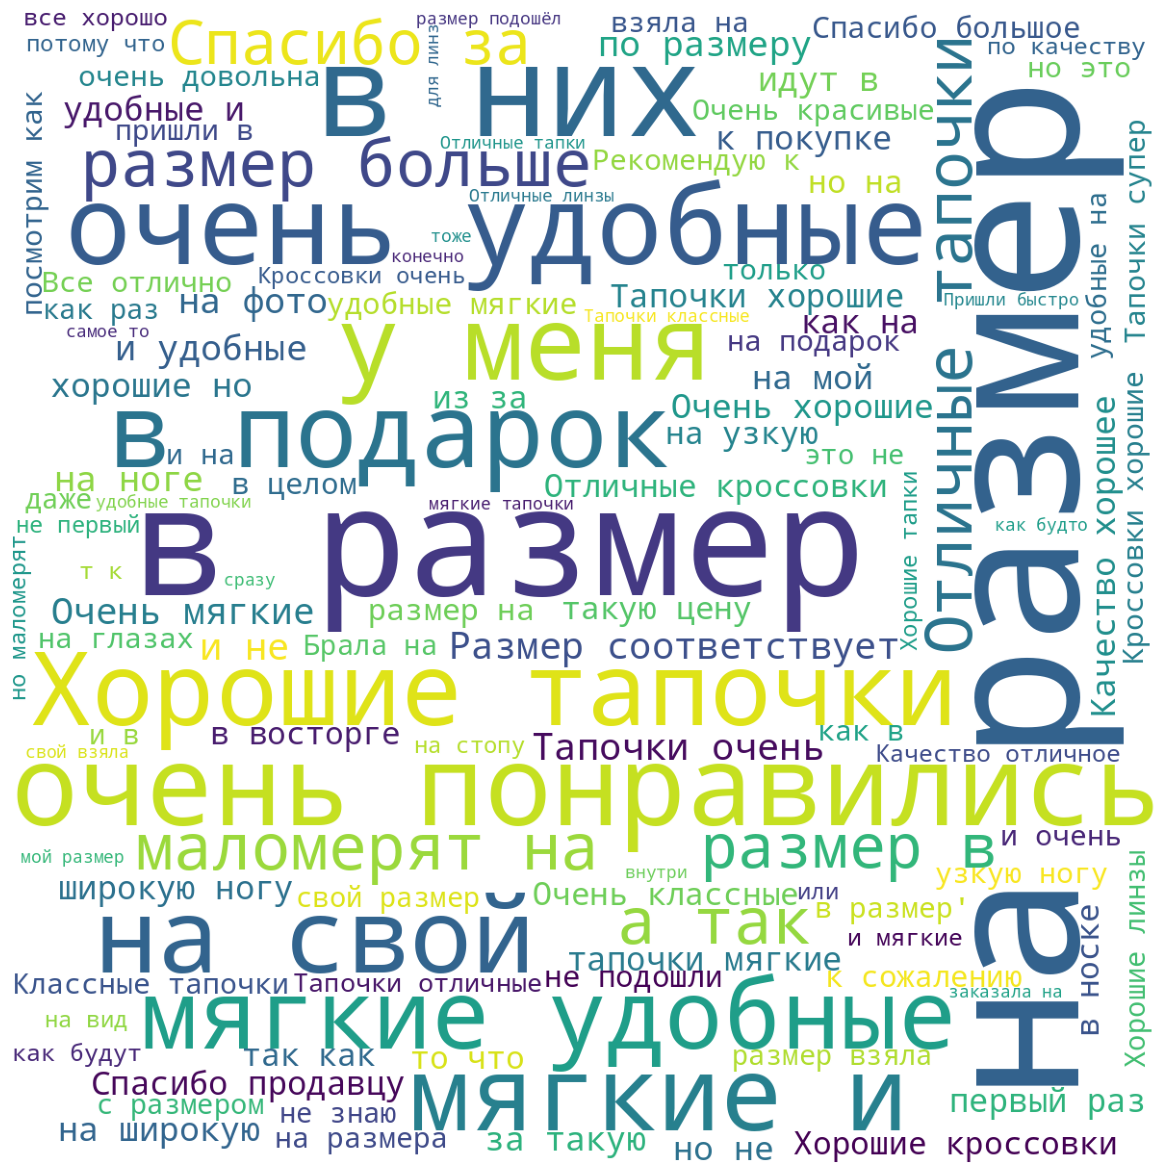

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text=str(list(df["text"]))
plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Axes: xlabel='count', ylabel='word'>

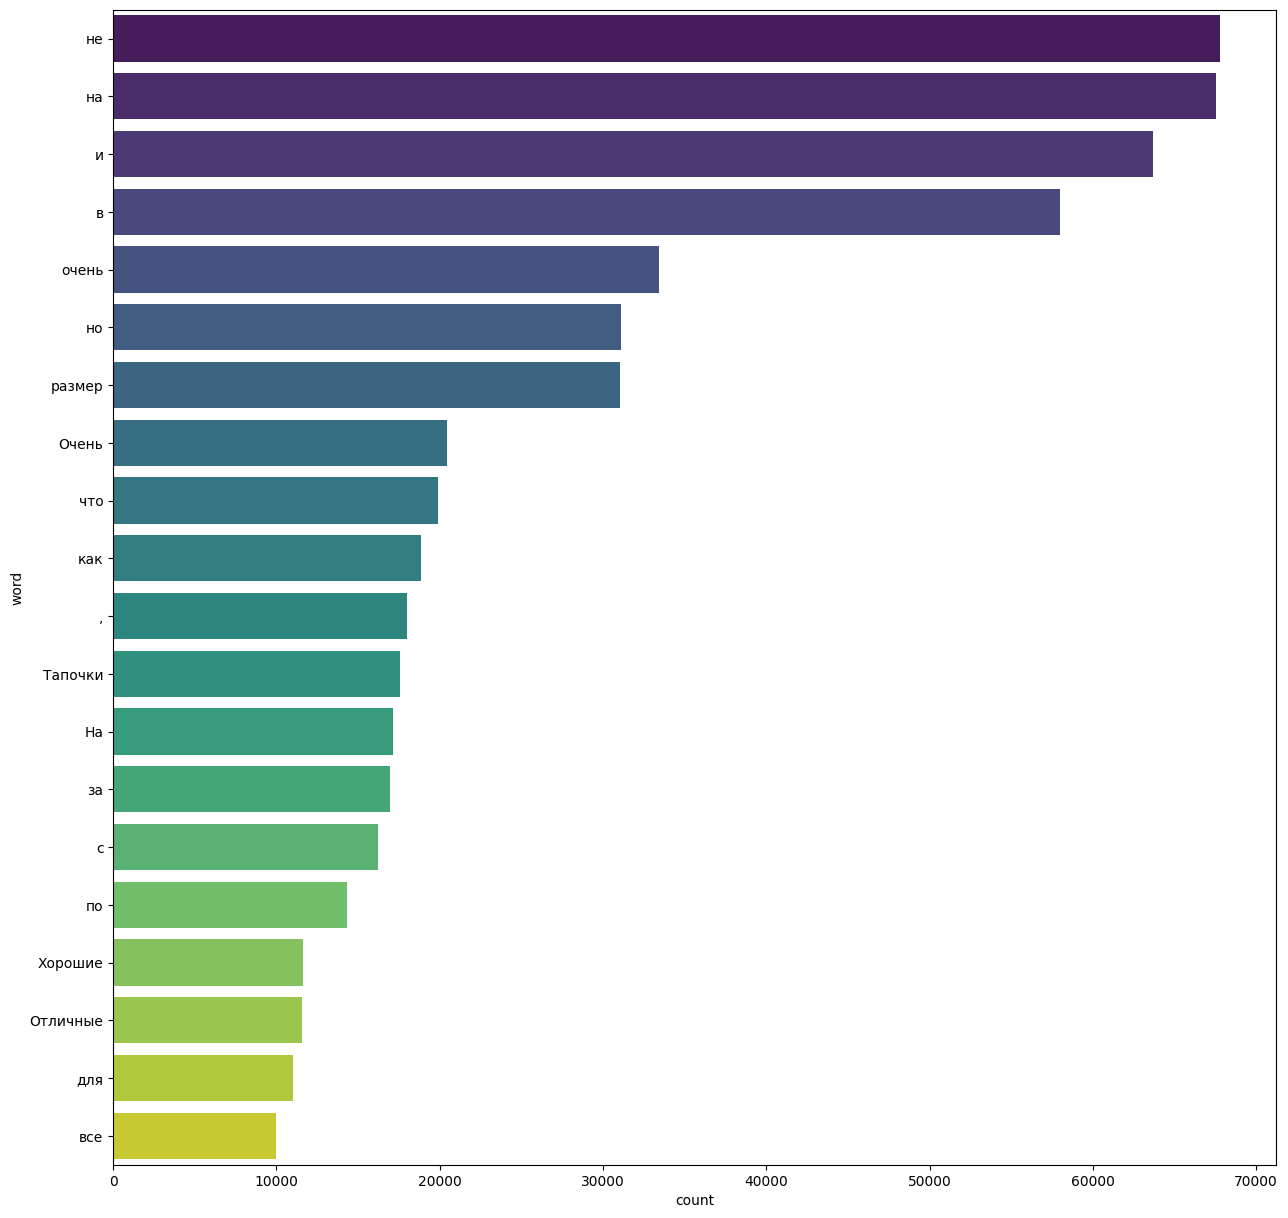

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

most_words_df = pd.DataFrame(word_counts.most_common()[:20], columns = ['word', 'count'])

plt.figure(figsize=(15,15))
# plt.subplot(2,1,1)
sns.barplot(data=most_words_df[:20].sort_values(by="count",ascending=False) ,y="word",x="count",palette="viridis")

Классы в датасете сильно несбалансированны, придется использовать взвешенный семплер

##Подготовка датасета

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ReviewsDataset(Dataset):
    def __init__(self, text, target, tokenizer):
       self.tokenizer = tokenizer
       self.target = target.tolist()
       self.input_ids, self.attention_mask = self.create_text(text)

    def create_text(self, text):
        # Функция для токенизации текста
        tokenized = tokenizer(text.tolist(),
                              padding=True,
                              truncation=True,
                              return_tensors="pt")

        return tokenized['input_ids'], tokenized['attention_mask']

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return ({'input_ids': self.input_ids[idx, :],
                 'attention_mask': self.attention_mask[idx, :]},
                self.target[idx])

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer

X_train, X_val, y_train, y_val = train_test_split(df['lemmatize_text'], df['label_id'], test_size=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print("X_train shape: ", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape: ", X_test.shape)

tokenizer = BertTokenizer.from_pretrained("seara/rubert-tiny2-russian-sentiment")

train_ds = ReviewsDataset(X_train, y_train, tokenizer)
test_ds = ReviewsDataset(X_test, y_test, tokenizer)
val_ds = ReviewsDataset(X_val, y_val, tokenizer)

X_train shape:  (174680,)
X_val shape: (22834,)
X_test shape:  (30826,)


tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import WeightedRandomSampler
from collections import Counter

# Подсчет весов для классов
cnt = Counter(y_train)
cnt = {k: 1/v for k, v in cnt.items()}
sample_weights = np.array([cnt[i] for i in y_train])
batch_s = 32

train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_ds), replacement=True)

train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_s, sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_s, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_s)

Семплер работает - классы подаются в сопоставимом количестве

In [ ]:
Counter(torch.tensor(next(iter(train_dataloader))[1]).tolist())

<ipython-input-16-aeb869b66e74>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Counter(torch.tensor(next(iter(train_dataloader))[1]).tolist())


Counter({0: 10, 2: 8, 1: 14})

##Обучение модели
Для обучения я использовал обычный цикл с кросс-энтропией в виде функции потерь и Adam оптимизатором, метрики - F1 и accuracy, в качестве модели я взял rubert-tiny2 и дообучил его. Для логгирования результатов обучения и чекпоинтов модели я использовал wandb.

In [ ]:
from google.colab import output
from sklearn.metrics import f1_score


def train(model, train_dataloader, optimizer, criteron, run):
    model.train()
    total_loss = 0
    k = 0

    for batch in tqdm(train_dataloader, desc = 'train'):
        input_ids = batch[0]['input_ids'].to(device)
        attention_mask = batch[0]['attention_mask'].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        outputs=model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()
        total_loss += loss.item()

        optimizer.step()

        _, predicted = logits.max(1)
        total = labels.size(0)
        correct = predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total
        train_f1 = f1_score(labels.cpu(), predicted.cpu(), average = 'weighted')

        wandb.log({'train_loss': loss.item()})
        wandb.log({'train_acc': train_accuracy})
        wandb.log({'f1_score': train_f1})

        k += 1
        if k%100 == 0:
            output.clear()

    wandb.log({'train_epoch_loss': total_loss})
    torch.save(model.state_dict(), '/content/drive/MyDrive/.../model.pth')
    artifact = wandb.Artifact('rubert-tiny', type='model')
    artifact.add_file('/content/drive/MyDrive/.../model.pth')
    run.log_artifact(artifact)

def validate(model, valid_dataloader, criterion):
    model.eval()
    total_correct = 0
    total_size = 0
    k = 0

    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc = 'val'):
            input_ids = batch[0]['input_ids'].to(device)
            attention_mask = batch[0]['attention_mask'].to(device)
            labels = batch[1].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)

            val_loss = loss.item()
            _, predicted = logits.max(1)

            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            total_correct += correct
            total_size += total

            val_accuracy = 100 * correct / total
            val_f1 = f1_score(labels.cpu(), predicted.cpu(), average = 'weighted')

            wandb.log({'val_loss': val_loss})
            wandb.log({'val_acc': val_accuracy})
            wandb.log({'f1_score': val_f1})

            k += 1
            if k%100 == 0:
                output.clear()

        wandb.log({'val_accuracy': total_correct / total_size * 100})

In [ ]:
from transformers import BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('seara/rubert-tiny2-russian-sentiment', num_labels=3)
model = DataParallel(model)
model = model.to(device)

optimizer = optim.Adam(model.parameters(),lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

import wandb
run = wandb.init()
artifact = run.use_artifact('glebshevtsov24/Reviews.../model:v2', type='model')
artifact_dir = artifact.download()
run.finish()

In [ ]:
model.load_state_dict(torch.load('/content/artifacts/model:v2/model.pth'))

<All keys matched successfully>

In [ ]:
run = wandb.init(
    project="Reviews...",
    name = 'RuBertTiny...'
)

for epoch in tqdm(range(1)):
    train(model, train_dataloader, optimizer, criterion, run)
    validate(model, val_dataloader, criterion)

wandb.finish()

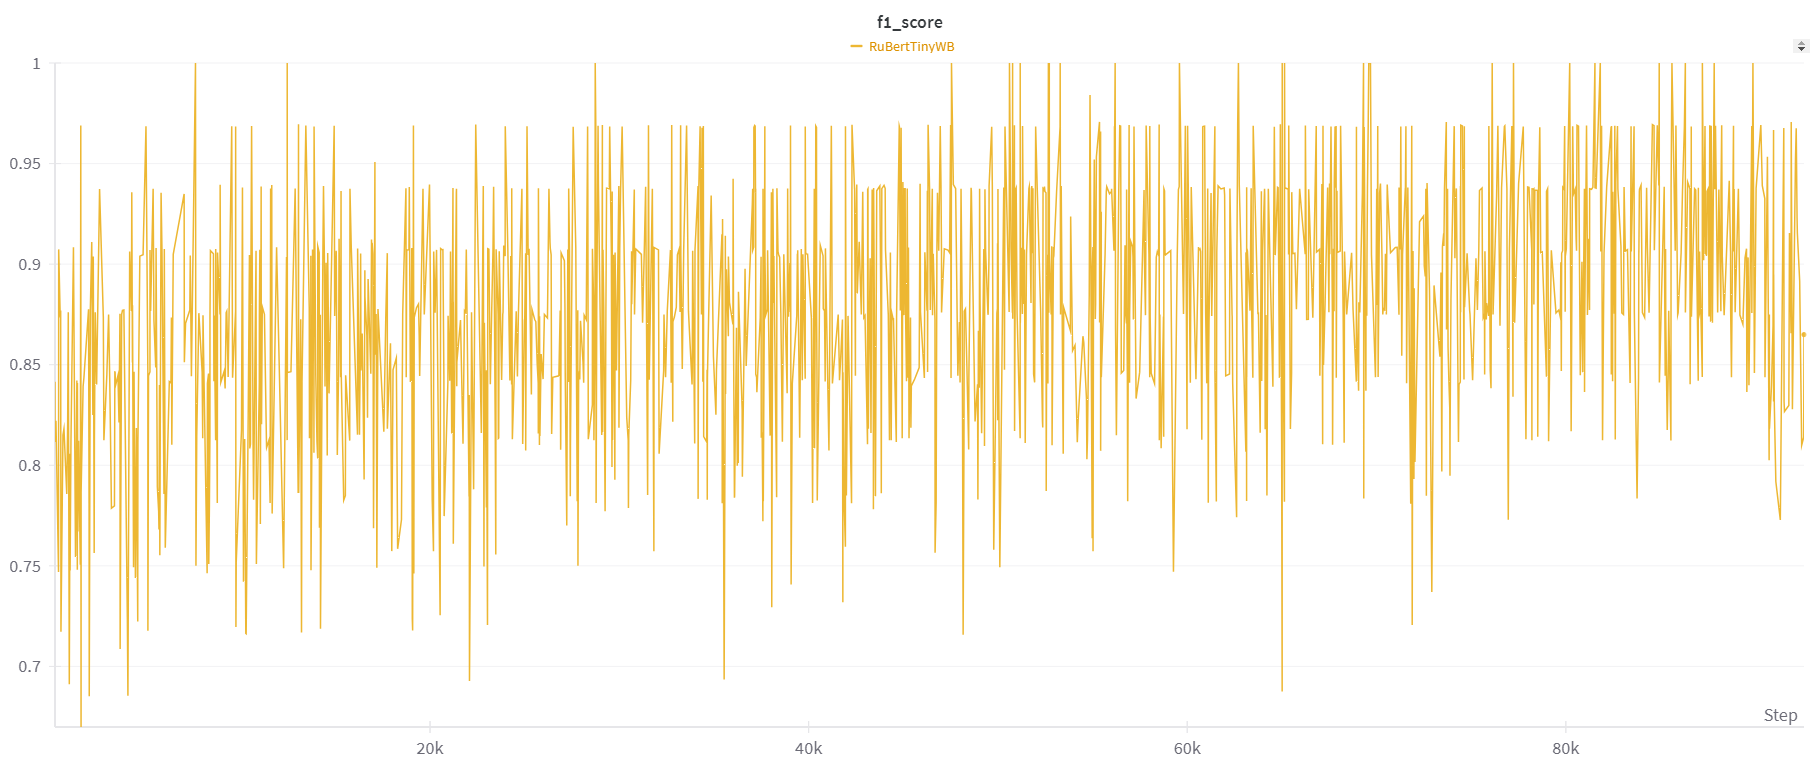
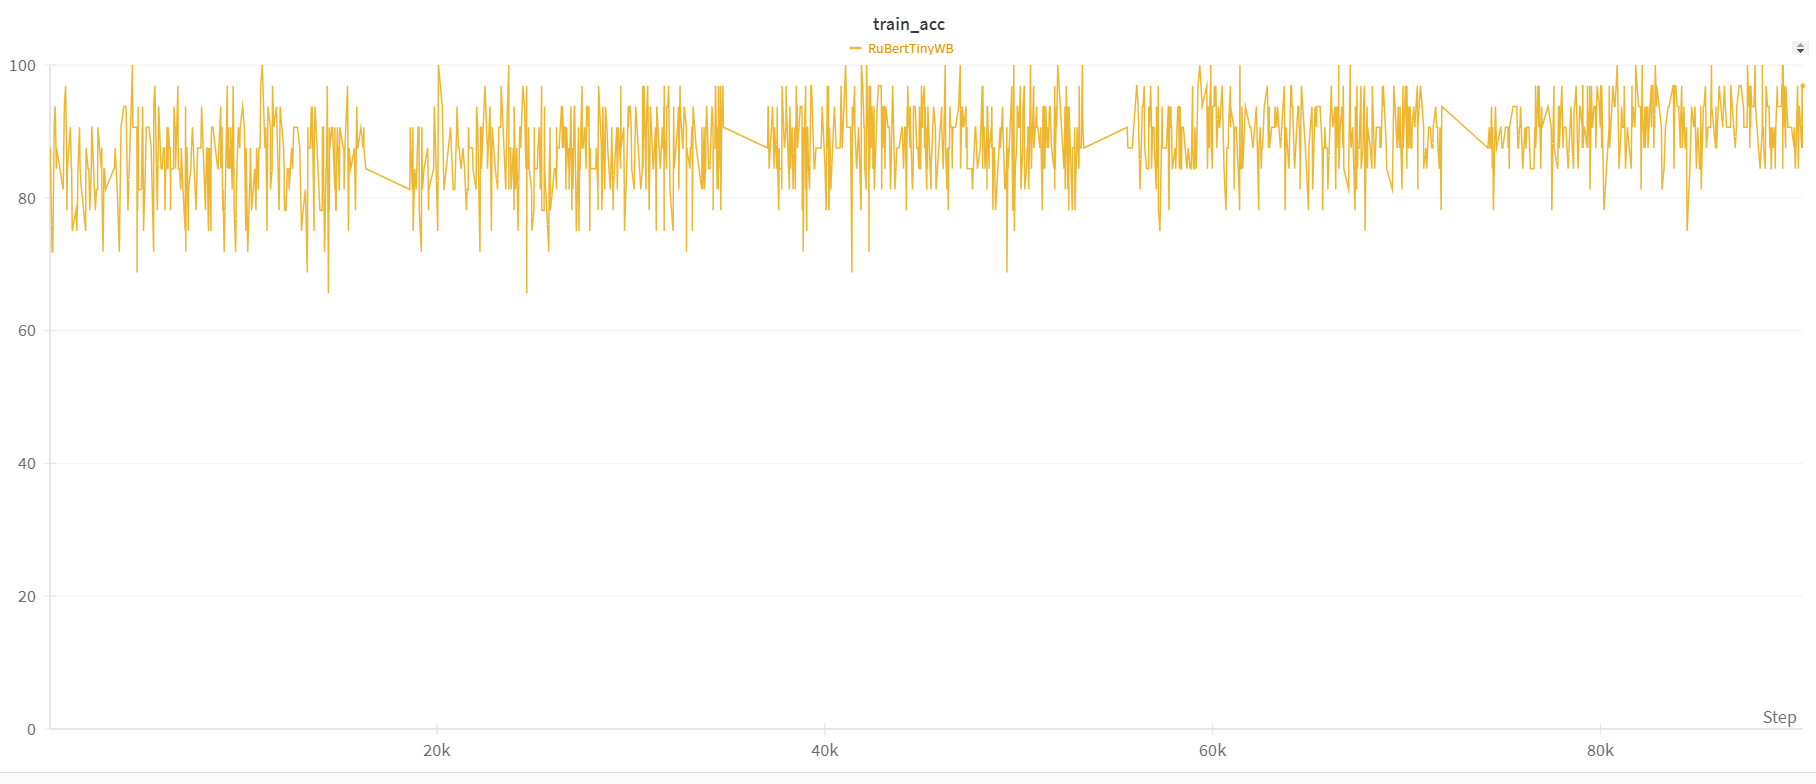
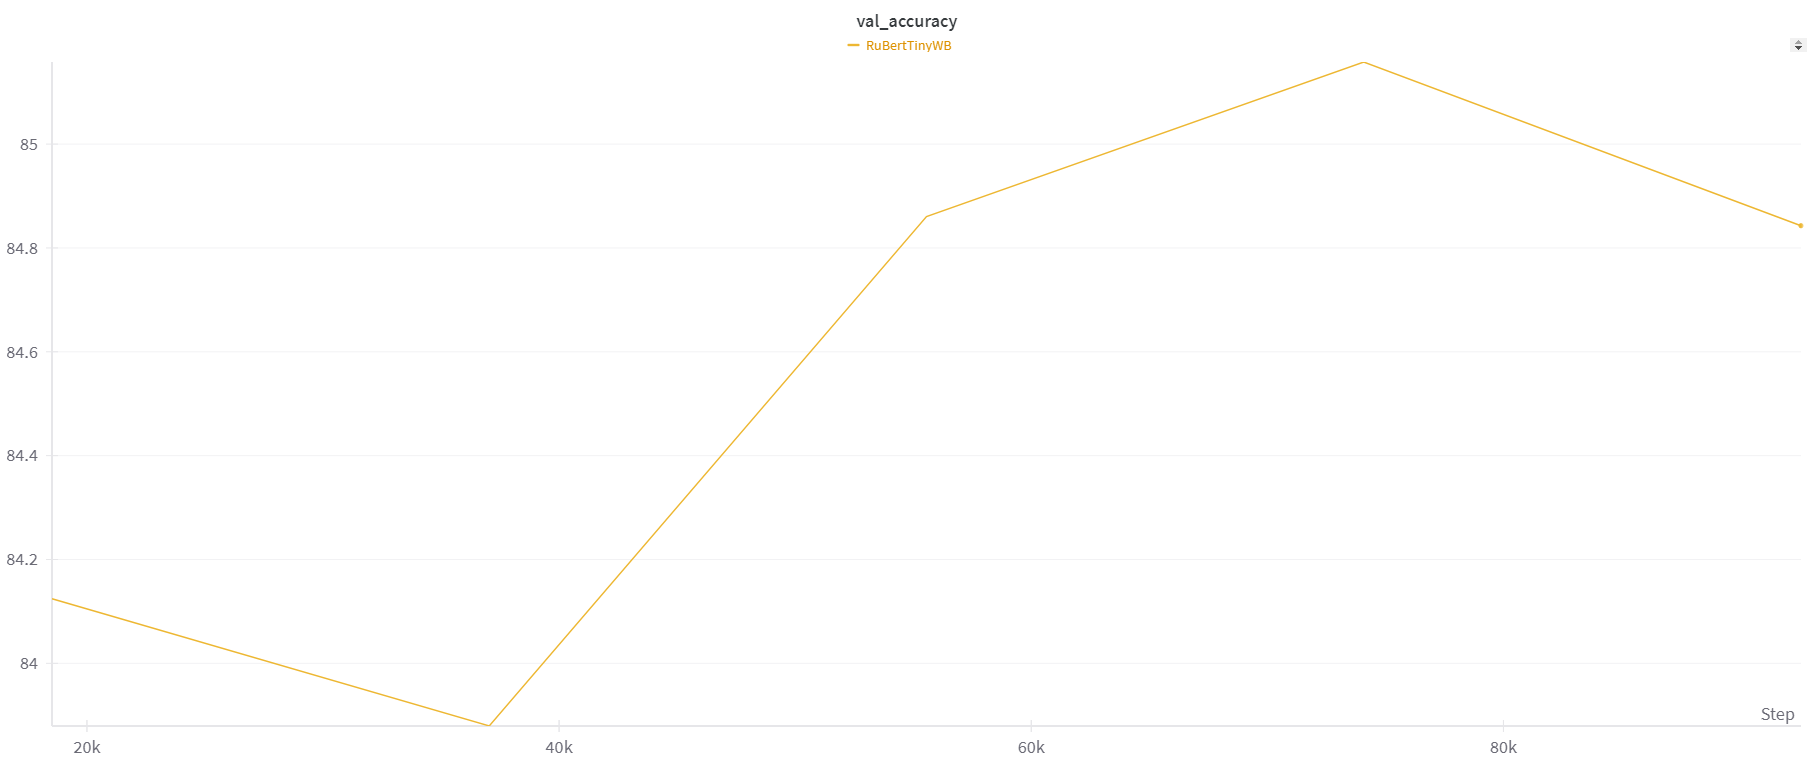

In [ ]:
predictions=[]
actual_labels=[]

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch[0]['input_ids'].to(device)
        attention_mask = batch[0]['attention_mask'].to(device)
        labels = batch[1].to(device)

        outputs = model(input_ids, attention_mask = attention_mask)
        logits = outputs.logits

        _, predicted = logits.max(1)

        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

results_df = pd.DataFrame({"Actual": actual_labels, "Predicted": predictions})
results_df

100%|██████████| 964/964 [00:17<00:00, 53.84it/s]


,Actual,Predicted
0,2,2
1,2,2
2,0,0
3,2,2
4,2,2
...,...,...
30821,0,2
30822,0,1
30823,2,2
30824,1,2


In [ ]:
from sklearn.metrics import f1_score
f1_score(actual_labels, predictions, average = 'weighted'), \
f1_score(actual_labels, predictions, average='macro'), \
f1_score(actual_labels, predictions, average='micro')

(0.9121118093827482, 0.668235638122888, 0.9174722636735223)

<Axes: >

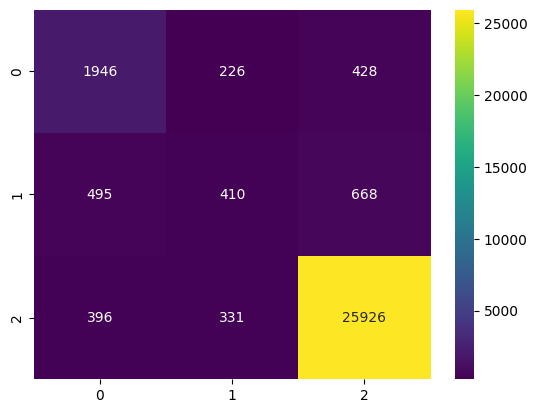

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

confusionMatrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusionMatrix, annot=True, cmap='viridis', fmt='g')